In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objs as go

In [3]:
path = "/Users/coes3/phd-labs/fraganal/data_source/shut/"
filepath = "/Users/coes3/phd-labs/fraganal/data_source/cc_alpha2.csv"

In [4]:
def data_prep(path):
    files = Path(path).glob('*.csv')
    dfs = []

    for i in files:
        data = pd.read_csv(i, header=0)
        dfs.append(data)

    df = pd.concat(dfs, ignore_index=True)

    cc_df = pd.read_csv(filepath)
    df = df.join(cc_df.set_index('Name'), on='country')
    df.rename(columns = {'Code':'cc'}, inplace = True)

    cc_list = ['CN','BR','DE','IN','IQ', 'RW']
    df = df[df['cc'].isin(cc_list)]

    #columns = ['start_date', 'end_date', 'cc', 'geo_scope', 'shutdown_type', 
    #           'affected_network', 'shutdown_extent']
    #df = df[columns]

    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])

    #  filter for only 2022 data 
    df = df.loc[(df['start_date'] >= '2022-01-01') & (df['start_date'] <='2022-12-31')]
    
    #  rewrite text for geo_scope
    df['geo_scope'].replace('It affected locations in more than one state, province, or region','Country', inplace=True)
    df['geo_scope'].replace('It affected more than one city in the same state, province, or region','State', inplace=True)
    df['geo_scope'].replace('It only affected one city, county, or village','City', inplace=True)
    df['geo_scope'].replace('Not sure','Unknown', inplace=True)
    
    #  drop any row without a start or end date
    df.dropna(subset=['start_date', 'end_date'], inplace=True)
    
    #  create a duration column with day numbers betwee start and end date
    df['duration'] = df['end_date'] - df['start_date']
    df['duration'] = df['duration'].astype('timedelta64[D]')
    df.drop(columns=['end_date'], inplace=True)
    df.rename(columns = {'start_date':'date'}, inplace = True)
    df['event_count'] = 1
    #df.set_index('date', inplace=True)
    
    return df

In [5]:
df = data_prep(path)

In [6]:
df

,start_date_type,date,country,geo_scope,area_name,shutdown_type,affected_network,shutdown_extent,ordered_by,decision_maker,...,hr_abuse_reported,users_targeted,users_target_detail,users_notified,econ_impact,event,an_link,Duration,cc,event_count
17,Actual,2022-01-03,India,City,"Srinagar, Jammu & Kashmir",Shutdown,Mobile,Full network,State government,"Government of Jammu & Kashmir, Home Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in Srinagar from...,NaN,NaN,IN,1
19,Actual,2022-01-05,India,City,"Pulwama, Jammu & Kashmir",Shutdown,Mobile,Full network,State government,"Government of Jammu & Kashmir, Home Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in Pulwama from ...,NaN,NaN,IN,1
20,Actual,2022-01-06,India,City,"Srinagar, Jammu & Kashmir",Shutdown,Mobile,Full network,State government,"Government of Jammu & Kashmir, Home Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in Srinagar from...,NaN,NaN,IN,1
22,Actual,2022-01-09,India,City,"Kulgam, Jammu & Kashmir",Shutdown,Mobile,Full network,State government,"Government of Jammu & Kashmir, Home Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in Kulgam from 1...,NaN,NaN,IN,1
23,Actual,2022-01-09,India,City,"Srinagar, Jammu & Kashmir",Shutdown,Mobile,Full network,State government,"Government of Jammu & Kashmir, Home Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in Srinagar from...,NaN,NaN,IN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Estimated,2022-11-13,India,City,"Chakradharpur, Jharkhand",Shutdown,Unknown,Full network,Unknown,NaN,...,Unknown,NaN,NaN,Unknown,NaN,There was an internet shutdown in Chakradharpu...,NaN,NaN,IN,1
175,Actual,2022-11-22,India,State,Meghalaya,Shutdown,Mobile,Full network,State government,"Government of Meghalaya, Home (Police) Department",...,Unknown,NaN,NaN,No,NaN,Mobile internet was suspended in 7 districts a...,NaN,NaN,IN,1
177,Actual,2022-11-24,India,City,"Bhilwara, Rajasthan",Shutdown,Unknown,Full network,Law enforcement,NaN,...,Unknown,NaN,NaN,No,NaN,"Internet services were suspended in Bhilwara, ...",NaN,NaN,IN,1
179,Actual,2022-12-03,India,City,"Sirohi, Rajasthan",Shutdown,Mobile,Full network,Local government,NaN,...,Unknown,Dalit community,NaN,No,NaN,Internet services were suspended for 48 hours ...,NaN,NaN,IN,1


In [163]:
df.groupby('cc', as_index=False).sum() #Days of shutdowns per country

,cc,duration,event_count
0,BR,2.0,1
1,IN,152.0,80
2,IQ,24.0,1


In [164]:
df.groupby('cc', as_index=False).size() #occurances of shutdowns per country

,cc,size
0,BR,1
1,IN,80
2,IQ,1


In [165]:
df2 = df.groupby(['date','cc', 'shutdown_extent','geo_scope'])['duration'].agg(['sum','count'])

In [170]:
df

,date,cc,geo_scope,shutdown_type,affected_network,shutdown_extent,duration,event_count
17,2022-01-03,IN,City,Shutdown,Mobile,Full network,2.0,1
19,2022-01-05,IN,City,Shutdown,Mobile,Full network,0.0,1
20,2022-01-06,IN,City,Shutdown,Mobile,Full network,2.0,1
22,2022-01-09,IN,City,Shutdown,Mobile,Full network,1.0,1
23,2022-01-09,IN,City,Shutdown,Mobile,Full network,2.0,1
...,...,...,...,...,...,...,...,...
171,2022-11-13,IN,City,Shutdown,Unknown,Full network,1.0,1
175,2022-11-22,IN,State,Shutdown,Mobile,Full network,6.0,1
177,2022-11-24,IN,City,Shutdown,Unknown,Full network,2.0,1
179,2022-12-03,IN,City,Shutdown,Mobile,Full network,2.0,1


In [42]:
df2 = df.groupby(['date','cc', 'shutdown_extent','geo_scope'])['duration'].agg(['sum','count'])
df2.reset_index(inplace=True)
df2.rename(columns={"count":"event_count", "sum":"duration"}, inplace = True)

In [172]:
df2 = df.groupby(['date','cc', 'shutdown_extent', 'geo_scope','duration'])['duration'].agg(['count'])
df2.reset_index(inplace=True)
df2.rename(columns={"count":"event_count", "sum":"duration"}, inplace = True)

In [180]:
def plot_graph(df):    
    fig = px.scatter(df2, x="date", y="geo_scope", color="shutdown_extent", size='duration', facet_col="cc",facet_col_wrap=3, 
                     hover_data=['duration'], template='simple_white')
    
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b",
        showgrid=False)
    fig.show()

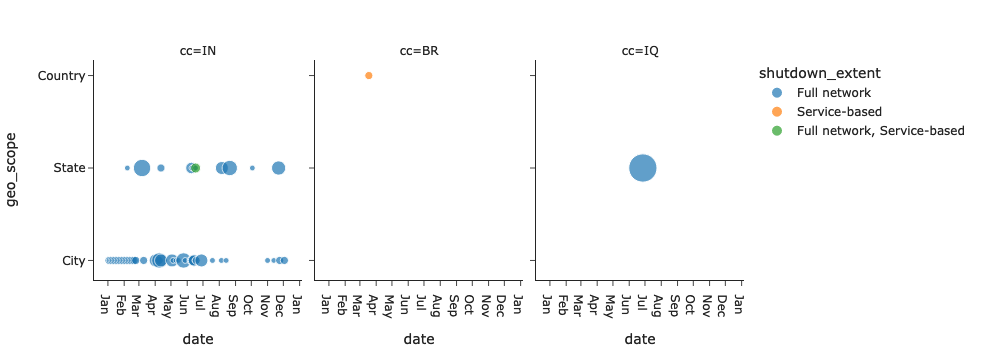

In [181]:
plot_graph(df2)

In [187]:
def plot_graph_bar(df, cc):
    df = df.loc[df['cc'] == cc]
    df.set_index('date', inplace=True)
    df2 = df.resample('M').mean().round(0)
    fig = px.bar(df2, x=df2.index, y="duration", hover_data=['duration'], template='simple_white')
    
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b",
        showgrid=False)
    fig.show()

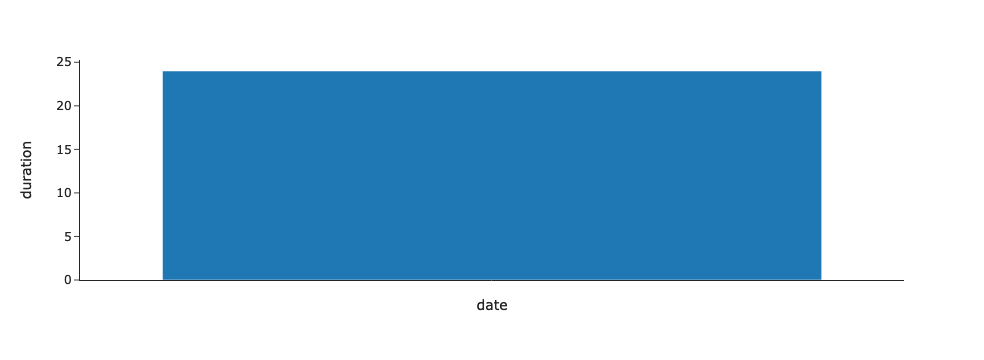

In [190]:
plot_graph_bar(df, 'IQ')

In [123]:
dfmon = df.resample('M').mean().round(1)

In [124]:
dfmon

,duration,event_count
start_date,,
2022-01-31,1.5,1.0
2022-02-28,1.7,1.0
2022-03-31,3.2,1.0
2022-04-30,3.0,1.0
2022-05-31,1.3,1.0
2022-06-30,3.3,1.0
2022-07-31,1.0,1.0
2022-08-31,2.8,1.0
2022-09-30,0.0,1.0
